In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
from diffusers import DiffusionPipeline
import torch
import gc

pipe = DiffusionPipeline.from_pretrained("Alpha-VLLM/Lumina-Image-2.0", torch_dtype=torch.bfloat16)
pipe.enable_model_cpu_offload()
pipe.to('cuda')

/home/j-i12b106/.conda/envs/diffusion/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]
It seems like you have activated model offloading by calling `enable_model_cpu_offload`, but are now manually moving the pipeline to GPU. It is strongly recommended against doing so as memory gains from offloading are likely to be lost. Offloading automatically takes care of moving the individual components vae, text_encoder, tokenizer, transformer, scheduler to GPU when needed. To make sure offloading works as expected, you should consider moving the pipeline back to CPU: `pipeline.to('cpu')` or removing the move altogether if you use offloading.


Lumina2Text2ImgPipeline {
  "_class_name": "Lumina2Text2ImgPipeline",
  "_diffusers_version": "0.33.0.dev0",
  "_name_or_path": "Alpha-VLLM/Lumina-Image-2.0",
  "scheduler": [
    "diffusers",
    "FlowMatchEulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "Gemma2Model"
  ],
  "tokenizer": [
    "transformers",
    "GemmaTokenizerFast"
  ],
  "transformer": [
    "diffusers",
    "Lumina2Transformer2DModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

100%|██████████| 30/30 [03:24<00:00,  6.82s/it]


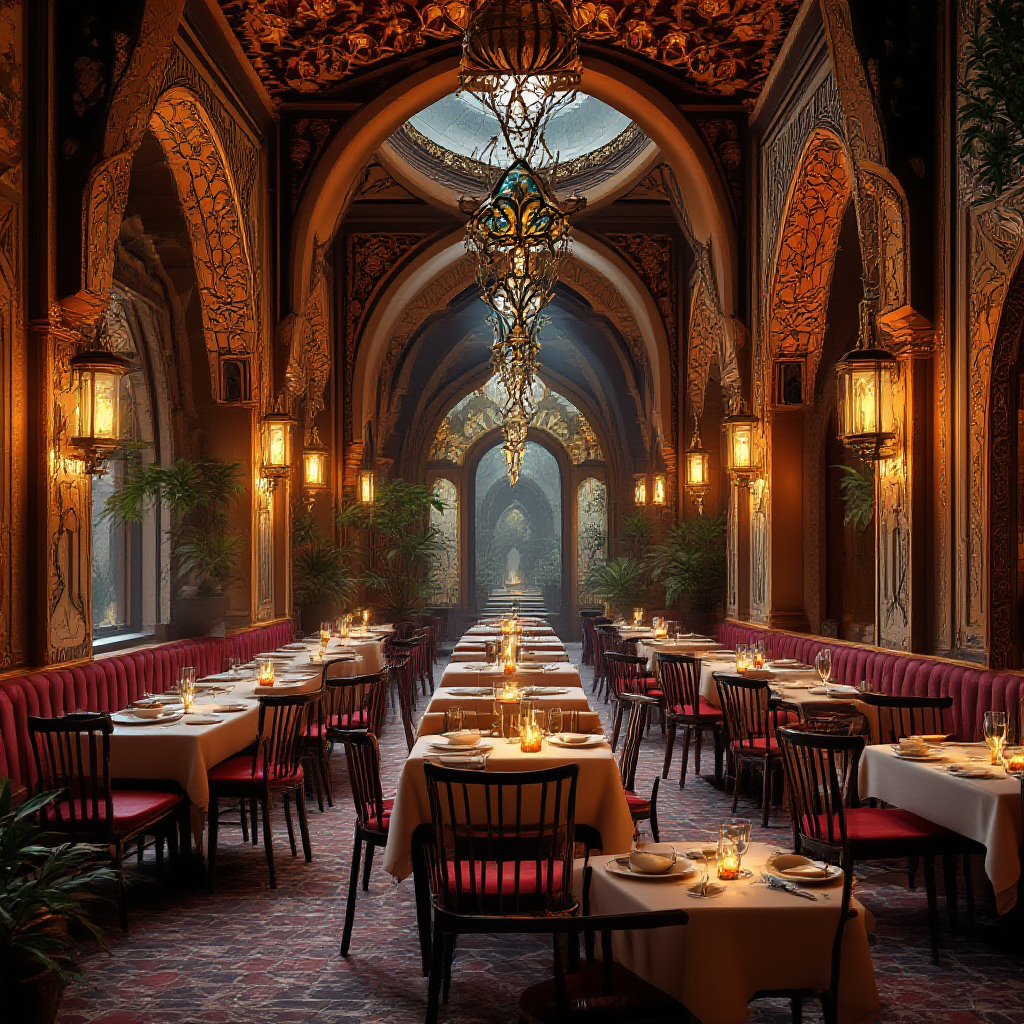

In [7]:
prompt = """
mystical fantasy restaurant in ghibri style
"""
image = pipe(prompt).images[0]
image.show()

In [3]:
# import gc
# import torch
# from diffusers import StableDiffusionXLPipeline, AutoPipelineForText2Image

# # 모델 ID (Hugging Face 경로, 또는 로컬에 다운로드한 모델 경로 사용)
# base_model_id = "cagliostrolab/animagine-xl-3.0"

# from diffusers import StableDiffusionPipeline
# import torch

# # Stable Diffusion XL 모델 로드
# model_id = "cagliostrolab/animagine-xl-3.0"
# pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
# pipe.to("cuda")

# # LoRA 모델 적용
# lora_model_id = "ostris/watercolor_style_lora_sdxl"  # 원하는 LoRA 모델 ID로 변경
# pipe.unet.load_attn_procs(lora_model_id)

# # 이미지 생성
# prompt = "A futuristic cityscape in retro style"
# image = pipe(prompt).images[0]
# image.show()

# image_styles = {
#     # "retro": {
#     #     "model_id": ["coder119/Vectorartz_Diffusion", "stablediffusionapi/samdoesarts-ultmerge"],
#     #     # "prompt": "((masterpiece)), ((best quality)), retro-style illustration, vintage poster, old-school print, ((golden flying croaker fish)), vibrant color, grainy texture, 1980s aesthetic, faded colors, hand-drawn lines, soft shading, limited color palette, surreal atmosphere",
#     #     # "negative_prompt": "(worst quality, low quality:1.2), blurry, distorted, photorealistic, 3D render, neon, modern elements, overly detailed"
#     # },
#     # "realism": {
#     #     "model_id": ["SG161222/Realistic_Vision_V6.0_B1_noVAE", "digiplay/Photon_v1"],
#     #     # "prompt": "((masterpiece)), ((best quality)), photorealistic, 8k ultra-detailed, hyper-realistic golden croaker fish, flying in the sky, shimmering golden scales, realistic lighting, soft reflections, cinematic shot, sky background, soft clouds, DSLR photography, natural light",
#     #     # "negative_prompt": "(worst quality, low quality:1.2), blurry, noisy, cartoon, painting, illustration, extra limbs, distorted shape"
#     # },
#     # "comics": {
#     #     "model_id": ["daftstout/DDicon"],
#     #     # "prompt": "((masterpiece)), ((best quality)), comic book style, bold outlines, halftone shading, exaggerated perspective, ((golden flying croaker fish)), stylized ink drawing, vintage Marvel comics look, vibrant colors, strong contrast, dynamic pose, action shot",
#     #     # "negative_prompt": "(worst quality, low quality:1.2), blurry, photorealistic, watercolor, soft shadows"
#     # },
#     "cyberpunk": {
#         "model_id": ["ProGamerGov/Neon-Illustration-Diffusion", "stablediffusionapi/cetus-mix-whalefall2"],
#         # "prompt": "((masterpiece)), ((best quality)), cyberpunk art, futuristic neon city, glowing golden fish, ((golden flying croaker fish)), neon reflections, holographic effects, sci-fi environment, night sky, electric blue and purple tones, dynamic lighting, cinematic shot",
#         # "negative_prompt": "(worst quality, low quality:1.2), blurry, soft colors, monochrome, traditional painting"
#     },
#     "watercolor": {
#         "model_id": ["gokaygokay/Flux-Watercolor-Strokes-LoRA", "KappaNeuro/makoto-shinkai-style"],
#         # "prompt": "((masterpiece)), ((best quality)), watercolor painting, soft and delicate brushstrokes, dreamy atmosphere, ((golden flying croaker fish)), glowing golden scales, flowing in the sky, pastel color palette, light blue and white background, gentle lighting, airy composition",
#         # "negative_prompt": "(worst quality, low quality:1.2), blurry, overly saturated, sharp outlines, 3D render, photorealistic"
#     }
# }

In [4]:
def split_colon(s: str):
    return s.split(': ')[1]

def prompt_parser(s: str):
    prompt, negative_prompt = map(split_colon, s.split('\n'))
    return prompt, negative_prompt

from transformers import CLIPTokenizer

def truncate_prompt(prompt, max_length=77):
    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
    tokens = tokenizer(prompt, truncation=True, max_length=max_length, return_tensors="pt")
    return tokenizer.decode(tokens["input_ids"][0], skip_special_tokens=True)

prompt = """
mystical fantasy restaurant, dimly lit alley, oriental wooden architecture, glowing red lanterns, eerie atmosphere, diverse fantasy races, human chef stirring mysterious purple soup, beastman eating exotic meat, elf examining rare mushrooms, dwarf drinking fermented glowing beverage, magical menu board with bizarre dishes, crimson moonlight filtering through the window, secretive and mystical ambiance
"""

# shortened_prompt = truncate_prompt(prompt)
# print(shortened_prompt)

# s = """Prompt: ((masterpiece)), ((best quality)), highly detailed, anime-style, ultra-detailed, ((dark sci-fi dystopia:1.2)), ((battle royale battlefield:1.3)), cinematic lighting, neon reflections, cyberpunk ruins, futuristic city skyline, war-torn landscape, stormy skies, glowing energy weapons, holographic interface, VF energy aura, (intense fight scene:1.3), (survival game setting:1.2), destruction, chaos, shattered glass, sparks flying, fire embers, dust particles, (mystical energy effects:1.3), lightning crackles, vibrant color contrast, dynamic action pose, highly expressive characters
# Negative prompt: (worst quality, low quality:1.2), blurry, poorly drawn, extra limbs, mutated hands, lowres, bad anatomy, bad composition, pixelated, watermark, text, (cartoonish style:1.2), overly bright, pastel colors"""

# prompt, negative_prompt = prompt_parser(s)

# """Prompt: ((masterpiece)), ((best quality)), highly detailed, anime-style, ultra-detailed, ((dark sci-fi dystopia:1.2)), ((battle royale battlefield:1.3)), cinematic lighting, neon reflections, cyberpunk ruins, futuristic city skyline, war-torn landscape, stormy skies, glowing energy weapons, holographic interface, VF energy aura, (intense fight scene:1.3), (survival game setting:1.2), destruction, chaos, shattered glass, sparks flying, fire embers, dust particles, (mystical energy effects:1.3), lightning crackles, vibrant color contrast, dynamic action pose, highly expressive characters
# Negative prompt: (worst quality, low quality:1.2), blurry, poorly drawn, extra limbs, mutated hands, lowres, bad anatomy, bad composition, pixelated, watermark, text, (cartoonish style:1.2), overly bright, pastel colors""".split(': ')

In [5]:
IMG_PATH = "./result_img"

loaded_adapters = set()

def gen_image(pipe, style, prompt, negative_prompt='', save=''):
    lora_model_id = style_lora_models[style]
    model_name = lora_model_id.split('/')[-1]
    if style in loaded_adapters:
        print(f"⚠️ Adapter '{style}' is already loaded. Skipping duplicate load.")
    else:
        pipe.load_lora_weights(lora_model_id, adapter_name=style)
        loaded_adapters.add(style)
        print(f"✅ Loaded Adapter: {style}")
        # LoRA 모델 적용 (PEFT 백엔드 사용)
    
    image = pipe(
        prompt,
        negative_prompt=negative_prompt,
        num_inference_steps=30,
    ).images[0]
    
    # 이미지 저장 및 출력
    if save:
        image.save(os.path.join(IMG_PATH, f"{style}-{model_name}") + '.png')
    image.show()

def gen_prompt(genre):
    # raw_prompt = """Prompt: ((masterpiece)), ((best quality)), highly detailed, anime-style, ultra-detailed, ((dark sci-fi dystopia:1.2)), ((battle royale battlefield:1.3)), cinematic lighting, neon reflections, cyberpunk ruins, futuristic city skyline, war-torn landscape, stormy skies, glowing energy weapons, holographic interface, VF energy aura, (intense fight scene:1.3), (survival game setting:1.2), destruction, chaos, shattered glass, sparks flying, fire embers, dust particles, (mystical energy effects:1.3), lightning crackles, vibrant color contrast, dynamic action pose, highly expressive characters
    # Negative prompt: (worst quality, low quality:1.2), blurry, poorly drawn, extra limbs, mutated hands, lowres, bad anatomy, bad composition, pixelated, watermark, text, (cartoonish style:1.2), overly bright, pastel colors"""
    raw_prompt = """Prompt: ((masterpiece)), ((best quality)), 8k, ultra-detailed, high detail, A bustling "괴식식당" (Strange Food Restaurant) interior, (anime style), 강철수 (Kang Cheol-soo), a lively young chef, stands behind the counter, preparing a dish. 린 (Rin) assists with a smile, Melia, the energetic herbalist, samples a dish with exaggerated delight, restaurant, (StudioGhibli.Redmond-V2 LoRA), chef outfit, food preparation, happy customers, (unique ingredients), cozy atmosphere, warm lighting, fantasy elements, action scene
    Negative prompt: ugly, deformed, noisy, blurry, distorted, out of frame, bad anatomy, extra limbs, poorly drawn face, mutated hands, floating limbs, disconnected limbs, blurry background, text, watermark, signature"""
    return raw_prompt

In [6]:
style_lora_models = {
    "real_anime": "prithivMLmods/Flux-Dev-Real-Anime-LoRA",
    "retro": "glif-loradex-trainer/insectagon_1997_anime",
    "anime": "Nishitbaria/Anime-style-flux-lora-Large",
    "3d_real": "https://huggingface.co/Shakker-Labs/FLUX.1-dev-LoRA-live-3D",
    "studio_ghibli": "alvarobartt/ghibli-characters-flux-lora",
    "3d_anime": "artificialguybr/3DRedmond-V1",
    "oldbook": "glif-loradex-trainer/lemnop_Old_Book_Illustrations",
    "watercolor": "SebastianBodza/Flux_Aquarell_Watercolor_v2",
    "comics": "glif-loradex-trainer/insectagon_COMICSTYLE1_prodigy"
}

In [ ]:
# raw_prompt = gen_prompt('')
# prompt, negative_prompt = prompt_parser(s)
# prompt = shortened_prompt

In [ ]:
# test all models
for style in style_lora_models:
    print(f"Generate image use {style}...")
    gen_image(pipe, style, f'(({style})), {prompt}', save=True)
    gc.collect()
        